<a href="https://colab.research.google.com/github/lizhicq/AI-course/blob/master/Ch06%20-%20linear_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
root = "/content/drive/My Drive/Aache/MLCC/"

In [1]:
import numpy as np 
import math 
from sklearn.metrics import mean_squared_error

### 数据准备部分

<class 'numpy.ndarray'>


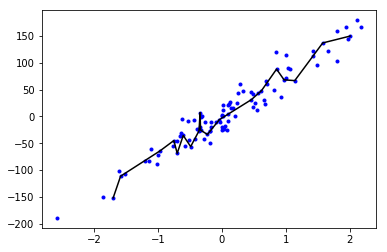

In [88]:
def shuffle_data(X,y,seed=None):
    "将X和y的数据进行随机排序/乱序化"
    if seed:
        np.random.seed(seed)
    idx=np.arange(X.shape[0])
    print(type(idx))
    np.random.shuffle(idx)
    return X[idx],y[idx] #对于np.array，idx作为index数组可以改变array的顺序

def train_test_split(X,y,test_size=0.5,shuffle=True,seed=None):
    '将数据集根据test_size分成训练集和测试集，可以指定是否随机洗牌'
    if shuffle:
        X,y=shuffle_data(X,y,seed)
    split_i=len(y)-int(len(y)//(1/test_size))
    #split_i=len(y)-int(len(y)*test_size)
    X_train,X_test=X[:split_i],X[split_i:]
    y_train,y_test=y[:split_i],y[split_i:]
    
    return X_train,X_test,y_train,y_test

from sklearn.datasets import make_regression
import matplotlib.pyplot as plt

X,y=make_regression(n_samples=100,n_features=1,noise=20, random_state=None)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

plt.plot(X,y,'b.')
#因为使用make_regression函数使得X乱序，在绘制matplot的图像时会有问题，所以对于X进行排序

s=sorted([(X_test[i][0],y_test[i]) for i in range(len(X_test))], key=lambda j:j[0])
X_test=np.array([[j[0]] for j in s])
y_test=np.array([j[1] for j in s])
plt.plot(X_test, y_test, 'k-') 

# 线性回归

[ 0.13974073 34.84184521]


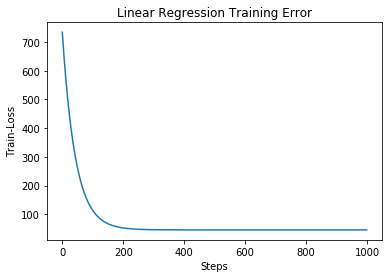

In [16]:
class Regression(object):
    
    """
        基础线性回归模型，使用输入的X和y进行参数回归
        超参：
        n_iterations:int 训练的步数
        learning_rate:float 学习率
        内部函数:
        initialize_weights:初始化参数
        fit:开始训练
        predict:预测
        内部的数据:
        n_iterations
        learning_rate
        regularization:正则化参数
        regularization.grad:正则化的梯度函数
    """
    
    def __init__(self,n_iterations,learning_rate):
        self.n_iterations=n_iterations
        self.learning_rate=learning_rate
        self.regularization=lambda x:0
        self.regularization.grad=lambda x:0
    
    def initialize_weights(self,n_features):
        """初始化系数，输入是feature的个数，输出是一个随机初始化好的参数矩阵,[-1/sqrt(N),1/sqrt(N)]"""
        limit=1/math.sqrt(n_features)
        self.w=np.random.uniform(-limit,limit,(n_features,))
    
    def fit(self,X,y):
        #插入偏置列1到X中
        X=np.insert(X,0,1,axis=1)#给每一行的第0列增加一个1
        self.training_errors=[]#保存每一次步长的训练Loss
        self.initialize_weights(n_features=X.shape[1])#初始化参数w
        
        #Gradient Decendent
        for i in range(self.n_iterations):
            y_pred=X.dot(self.w)#进行预测
            #计算Loss
            mse=np.mean(0.5*(y-y_pred)**2+self.regularization(self.w))
            self.training_errors.append(mse)#将Loss加入到training_errors的数组中
            #计算带有正则化项的梯度
            g_w=-(y-y_pred).T.dot(X)/len(X)+self.regularization.grad(self.w)
            #根据梯度下降的算法更新参数
            self.w-=self.learning_rate*g_w
            
    def predict(self,X):
        #通过输入X预测一个样本
        X=np.insert(X,0,1,axis=1)
        pred=X.dot(self.w)
        return pred
    
model=Regression(n_iterations=1000,learning_rate=0.01)
model.fit(X_train,y_train)
training,=plt.plot(range(len(model.training_errors)),model.training_errors,label="Training Error")
plt.title("Linear Regression Training Error")
plt.ylabel("Train-Loss")
plt.xlabel("Steps")
print(model.w)

### 评价模型

87.5851061425784


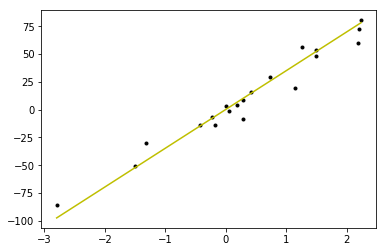

In [19]:
y_pred=model.predict(X_test)
mse=mean_squared_error(y_pred,y_test)
print(mse)
plt.plot(X_test,y_test,'k.')
plt.plot(X_test,y_pred,'Y')

### 带有最小二乘法的线性回归

In [20]:
def lsm_function(X,y):
    G=np.mat(np.insert(X,0,1,axis=1))
    return np.squeeze(np.asarray((G.T.dot(G)).I.dot(G.T).dot(y)))
lsm_function(X_train,y_train)
class LinearRegression(Regression):
    """带有最小二乘法的线性回归
    参数:
    -------------
    n_iterations
    
    learning_rate
    
    gradient_descent:bool 
        决定是否使用梯度下降法，如果是True则使用梯度下降，False使用最小二乘
    """
    def __init__(self,n_iterations=500,learning_rate=0.1,gradient_descent=True):
        self.gradient_descent=gradient_descent
        self.regularization=lambda x:0
        self.regularization.grad=lambda x:0
        super(LinearRegression,self).__init__(n_iterations=n_iterations,learning_rate=learning_rate)
    
    def fit(self,X,y):
        if not self.gradient_descent:
            self.w=lsm_function(X,y)
        else:
            super(LinearRegression,self).fit(X,y)
    
    def predict(self,X):
        return super(LinearRegression,self).predict(X)
        
model=LinearRegression(n_iterations=1000,learning_rate=0.1,gradient_descent=False)
model.fit(X_train,y_train)
print(model.w)

[ 0.14024649 34.84227422]


方差: 87.59119389190161


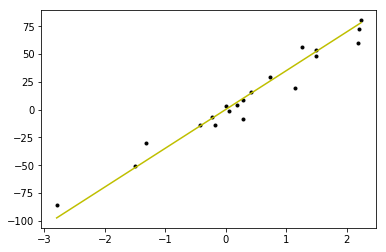

In [21]:
def test_and_draw(model):
    y_pred=model.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    print("方差:",mse)
    plt.plot(X_test,y_test,'k.')
    plt.plot(X_test,y_pred,'Y')
test_and_draw(model)

# 正则化回归

In [22]:
class l1_regularization():
    """L1正则化类/函数
    参数:
    
    alpha--L1正则化系数
    """
    def __init__(self,alpha):
        self.alpha=alpha
    def __call__(self,w):
        return self.alpha*np.linalg.norm(w,ord=1)
    def grad(self,w):
        #w>0->w`=1;w<0->w`=0;w==0->w`=0
        return self.alpha*np.sign(w)

l1=l1_regularization(alpha=0.01)
print(l1([-3,4]))
print(l1.grad([-3,4,0]))

0.07
[-0.01  0.01  0.  ]


### L2正则化参数

In [23]:
class l2_regularization():
    """L2正则化参数
    参数：
    
    alpha 正则化系数
    """
    def __init__(self,alpha):
        self.alpha=alpha
    
    def __call__(self,w):
        return self.alpha*0.5*w.T.dot(w)
    
    def grad(self,w):
        return self.alpha*w

## Lasso

[ 0.14024649 34.84227422]
方差: 87.59119389190121


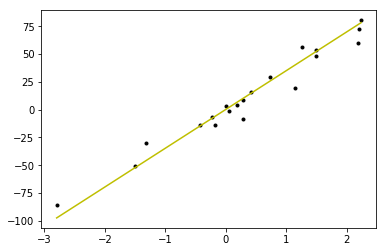

In [26]:
class LassoLinearRegression(Regression):
    def __init__(self,alpha,n_iterations=1000,learning_rate=0.01):
        self.regularization=l1_regularization(alpha=alpha)
        super(LassoLinearRegression,self).__init__(n_iterations,learning_rate)
        
    def fit(self,X,y):
        super(LassoLinearRegression,self).fit(X,y)
    def predict(self,X):
        return super(LassoLinearRegression,self).predict(X)

model=LassoLinearRegression(alpha=120,n_iterations=1000,learning_rate=0.1)
model.fit(X_train,y_train)
print(model.w)
test_and_draw(model)

## Ridged Reression 

[ 0.14024649 34.84227422]
方差: 87.59119389190121


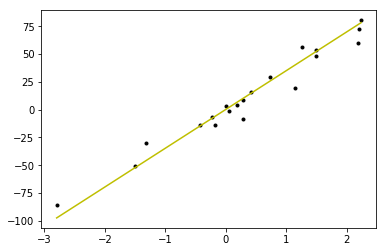

In [27]:
class RidgeLinearRegression(Regression):
    def __init__(self,alpha,n_iterations=1000,learning_rate=0.01):
        self.regularization=l2_regularization(alpha=alpha)
        super(RidgeLinearRegression,self).__init__(n_iterations,learning_rate)
        
    def fit(self,X,y):
        super(RidgeLinearRegression,self).fit(X,y)
    def predict(self,X):
        return super(RidgeLinearRegression,self).predict(X)

model = RidgeLinearRegression(alpha=120, n_iterations=1000, learning_rate=0.1)
model.fit(X_train, y_train)
print(model.w)
test_and_draw(model)

## L1, L2 调和的正则化

在调和的正则化中，

l1_ratio:调和时，L1正则化的值所占的百分比[0,1]

_l2_ratio=1-l1_ratio(事实上在算法中也找不到l2_ratio)

alpha:全局的整体的正则化权重

$Loss = mse + \alpha(l1\_ratio \times L1Loss + (1-l1\_ratio) \times L2Loss)$

In [29]:
class l1_l2_regularization():
    """使用在ElasticNet中的正则化"""
    
    def __init__(self,alpha,l1_ratio=0.5):
        self.alpha=alpha
        self.l1_ratio=l1_ratio
    
    def __call__(self,w):
        l1_loss=self.l1_ratio*np.linalg.norm(w,ord=1)
        l2_loss=(1-self.l1_ratio)*0.5*w.T.dot(w) #np.linalg.norm(w,ord=2)**2
        return self.alpha*(l1_loss+l2_loss)
    
    def grad(self,w):
        l1_grad=self.l1_ratio*np.sign(w)
        l2_grad=(1-self.l1_ratio)*w
        return self.alpha*(l1_grad+l2_grad)
l1_l2 = l1_l2_regularization(alpha=0.1)
print(l1_l2(np.array([3,4])))
print(l1_l2.grad(np.array([3,4])))
print(0.5 * np.sign(np.array([3,4])))
print(0.5 * np.array([3,4]))

0.9750000000000001
[0.2  0.25]
[0.5 0.5]
[1.5 2. ]


## ElasticNetLinearRegression

方差: 87.59119389189104


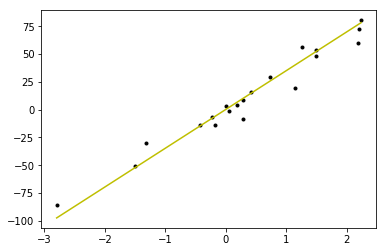

In [30]:
class ElasticNetLinearRegression(Regression):
    """
    ElasticNet线性回归算法
    ----------------------
    alpha:全局正则化参数
    l1_ratio:L1正则化参数比例
    n_iterations
    learning_rate
    """
    def __init__(self,alpha=0.05,l1_ratio=0.5,n_iterations=3000,learning_rate=0.01):
        self.regularization=l1_l2_regularization(alpha=alpha,l1_ratio=l1_ratio)
        super(ElasticNetLinearRegression,self).__init__(n_iterations,learning_rate)
    def fit(self,X,y):
        super(ElasticNetLinearRegression,self).fit(X,y)
    def predict(self,X):
        return super(ElasticNetLinearRegression,self).predict(X)
    
model=ElasticNetLinearRegression(l1_ratio=0.5,alpha=1.2)
model.fit(X_train,y_train)
test_and_draw(model)


# 多项式回归

一阶多项式:$x,y,z,x_2,x_3,x_4....$

二阶多项式:$x_1^2,x_2^2,x_3^2,x_1x_2,x_1x_3,x_2x_3$

三阶多项式:$x_1^3,x_1x_1x_2,x_1x_2x_3....$

In [99]:
from itertools import combinations_with_replacement

def polynomial_features(X,degree):
    n_samples,n_features=np.shape(X)
    ##对于每一行的Feature构造排列组合，根据排列组合进行特征的乘积，形成新的X`
    
    def index_combinations():
        combs=[combinations_with_replacement(range(n_features),i) for i in range(0,degree+1)]
        new_combs=[item for sub in combs for item in sub]
        return new_combs
    
    print("Feature 列的排列组合:->",[x for x in index_combinations()])
    #(0,0,1) ->(x0*x0*x1)
    comb=index_combinations()
    feature_length=len(comb)
    #print(n_samples, feature_length)
    output=np.empty((n_samples,feature_length)) # 初始化2*10，随机给值
    
    for i,index_combs in enumerate(comb):
        output[:,i] = np.prod(X[:, index_combs], axis=1)
    
    return output

print(polynomial_features(np.array([[1,2],[4,5]]), degree=3))

### combinations_with_replacement
#for x in combinations_with_replacement([0,1], 1):
#    print(x)

Feature 列的排列组合:-> [(), (0,), (1,), (0, 0), (0, 1), (1, 1), (0, 0, 0), (0, 0, 1), (0, 1, 1), (1, 1, 1)]
[[  1.   1.   2.   1.   2.   4.   1.   2.   4.   8.]
 [  1.   4.   5.  16.  20.  25.  64.  80. 100. 125.]]


Feature 列的排列组合:-> [(), (0,), (0, 0), (0, 0, 0)]
Feature 列的排列组合:-> [(), (0,), (0, 0), (0, 0, 0)]
方差: 1288.7972647445415


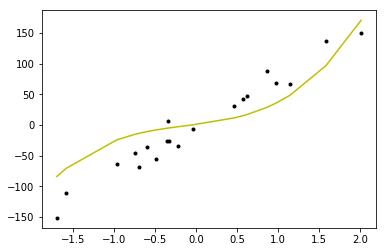

In [102]:
class PolyRegression(Regression):
    """多项式回归就是将原来的feature转化成多阶的新feature，之后进行线性回归:
    
    ------------------------------------------
    
    degree:最大的阶数
    
    n_iterations:float
    
    learning_rate:float
    
    """
    def __init__(self,degree,n_iterations=100,learning_rate=0.01):
        
        self.degree=degree
        
        self.regularization=lambda x:0
        
        self.regularization.grad=lambda x:0
        
        super(PolyRegression,self).__init__(n_iterations=n_iterations,learning_rate=learning_rate)
        
    def fit(self,X,y):
        
        X=polynomial_features(X,degree=self.degree)
        super(PolyRegression,self).fit(X,y)
        
    def predict(self,X):
        
        X=polynomial_features(X,degree=self.degree)
        
        return super(PolyRegression,self).predict(X)


model=PolyRegression(degree=3)
model.fit(X_train,y_train)
test_and_draw(model)
# 因为只有一个X， 所以就是X的0，1，2，3，次方